In [73]:
import pandas as pd
import datetime
import numpy as np

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
from datetime import datetime

from tqdm.auto import tqdm


plt.style.use('ggplot')

**Задание 1**

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [3]:
# Считываем данные
reg_data = pd.read_csv('problem1-reg_data.csv', sep = ';')

auth_data = pd.read_csv('problem1-auth_data.csv', sep = ';')

In [4]:
# смотрим на данные 
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
# смотри размеры датафрэймов
reg_data.shape

(1000000, 2)

In [7]:
# еще глянем все ли пользователи уникальные
reg_data.reg_ts.nunique() == reg_data.shape[0]


True

In [8]:
auth_data.shape

(9601013, 2)

In [9]:
# проверим есть ли пропущенные значений
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [10]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [11]:
# смотрим на типы данных
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [12]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [13]:
# смотрим описание 
reg_data.describe()

,reg_ts,uid
count,1.000000e+06,1.000000e+06
mean,1.548332e+09,5.552354e+05
std,5.253653e+07,3.206011e+05
min,9.113822e+08,1.000000e+00
25%,1.528034e+09,2.776438e+05
50%,1.564454e+09,5.550455e+05
75%,1.585759e+09,8.329712e+05
max,1.600874e+09,1.110622e+06


In [14]:
auth_data.describe()

,auth_ts,uid
count,9.601013e+06,9.601013e+06
mean,1.548778e+09,3.347198e+05
std,5.160527e+07,2.832669e+05
min,9.113822e+08,1.000000e+00
25%,1.528375e+09,9.599700e+04
50%,1.564577e+09,2.579210e+05
75%,1.585823e+09,5.190250e+05
max,1.600874e+09,1.110622e+06


**Вывод по данным:**
    - нет пропущенных значений
    - в таблице с регистрациями только уникальные пользователи
    - дата в обоих таблицах задана в формате epoch, для удобства потребуется перевести в формат даты.

In [15]:
# теперь напишим функцию которая считает Retention

def retention(reg = reg_data, 
              auth = auth_data,
              date_from = '1998-11-18', # введем переменные с датами, что бы устанавливать нужный промежуток,
              date_to = '2020-09-23',   # по умолчанию, весь датасэт
              number_of_days = 3):      # так же зададим какой промежуток дней интересен для расчета Retention
    
    # если в данных дата указана в интах, переводим ее в datetime, если нет идем дальше.
    if reg_data.reg_ts.dtypes == 'int64':
        reg['reg_ts'] = pd.to_datetime(reg['reg_ts'],unit='s').dt.to_period('D')
    if auth_data.auth_ts.dtypes == 'int64':
        auth['auth_ts'] = pd.to_datetime(auth['auth_ts'],unit='s').dt.to_period('D')
    
    # фильтруем данные по заданным нам датам
    reg = reg.query('reg_ts >= @date_from and reg_ts <= @date_to')
    
    # соединяем две таблицы в одну и берем только нужные нам столбцы
    df = auth.merge(reg, how = 'left', on = 'uid')
    df = df[['uid', 'reg_ts', 'auth_ts']]
    
    # групперуем по дате регистрации и по действиям, создаем когорты и считаем в них уникальных пользоватей
    cohort_df = df.groupby(['reg_ts', 'auth_ts'], as_index=False).agg(user_count=('uid', 'nunique'))
    
    # добавляем столбец с днями, который равен разнице между датой регистрации и датой совершения действия
    cohort_df['period_number'] = (cohort_df.auth_ts - cohort_df.reg_ts).apply(attrgetter('n'))
    
    # переворачиваем нашу таблицу     
    cohort_pivot = cohort_df.pivot_table(index='reg_ts', columns='period_number', values='user_count') \
                            .rename_axis('Day_of_registration')
    
    # задаем размер когорты и считаем retention
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_rate = cohort_pivot.divide(cohort_size, axis=0)
    
    # корректируем на нужное количество дней    
    retention_rate = retention_rate.iloc[:, 0:(number_of_days + 1)]
    
    # строим график    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    sns.heatmap(retention_rate,
            mask=retention_rate.isnull(),
            annot=True,
            fmt='.0%',
            cmap='OrRd',
            ax=ax[1])
    ax[1].set_title('Daily Retention', fontsize=16)
    ax[1].set(xlabel='Periods (№ of days)', ylabel='')
    cohort_size_df = pd.DataFrame(cohort_size) \
                             .rename(columns={0: 'cohort size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
            annot=True,
            cbar=False,
            fmt='g',
            cmap=white_cmap,
            ax=ax[0])
    fig.tight_layout()
    
    return fig.tight_layout(), retention_rate 

(None,
 period_number          0         1         2         3         4         5  \
 Day_of_registration                                                          
 2020-08-01           1.0  0.019244  0.044459  0.043132  0.055740  0.059058   
 2020-08-02           1.0  0.025845  0.040424  0.043738  0.051690  0.064944   
 2020-08-03           1.0  0.017196  0.042989  0.040344  0.055556  0.061508   
 2020-08-04           1.0  0.020476  0.035667  0.046896  0.052180  0.052840   
 2020-08-05           1.0  0.025709  0.034937  0.040211  0.057350  0.050758   
 2020-08-06           1.0  0.017117  0.050691  0.057275  0.055958  0.057275   
 2020-08-07           1.0  0.021682  0.030880  0.052562  0.053219  0.059790   
 2020-08-08           1.0  0.024278  0.047900  0.041995  0.054462  0.054462   
 2020-08-09           1.0  0.020956  0.039293  0.046496  0.053700  0.070727   
 2020-08-10           1.0  0.021583  0.031393  0.054938  0.058862  0.062786   
 2020-08-11           1.0  0.018930  0.043081

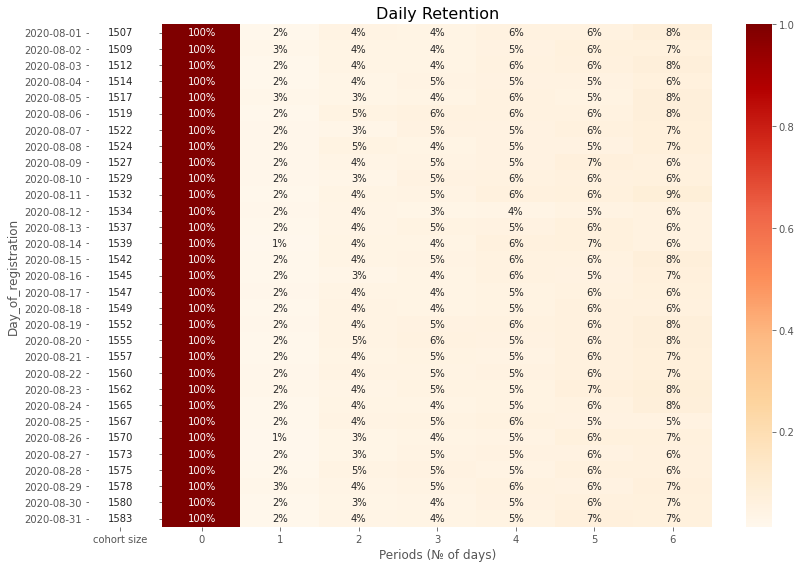

In [16]:
# запускаем нашу функцию
retention_1 = retention(reg_data, auth_data, date_from = '2020-08-01', date_to = '2020-08-31',  number_of_days = 6)
retention_1

(None,
 period_number         0         1         2         3         4         5   \
 Day_of_registration                                                          
 2019-09-20           1.0  0.020089  0.041295  0.049107  0.056920  0.063616   
 2019-09-21           1.0  0.018931  0.037862  0.055679  0.053452  0.050111   
 2019-09-22           1.0  0.026696  0.046719  0.043382  0.052280  0.062291   
 2019-09-23           1.0  0.015556  0.032222  0.038889  0.052222  0.052222   
 
 period_number              6         7         8         9         10  
 Day_of_registration                                                    
 2019-09-20           0.056920  0.061384  0.045759  0.051339  0.056920  
 2019-09-21           0.045657  0.067929  0.053452  0.047884  0.038976  
 2019-09-22           0.074527  0.058954  0.050056  0.054505  0.054505  
 2019-09-23           0.073333  0.057778  0.044444  0.044444  0.041111  )

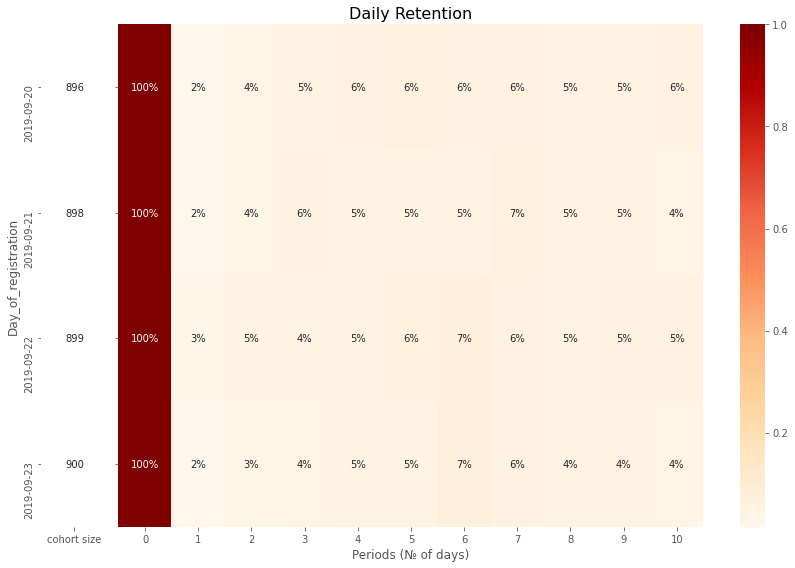

In [17]:
# пробуем еще на других датах
retention_2 = retention(reg_data, auth_data, date_from = '2019-09-20', date_to = '2019-09-23',  number_of_days = 10)
retention_2

**Задание 2**
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [74]:
# считываем данные для задания 2
df2 = pd.read_csv('Проект_1_Задание_2.csv', sep = ';')

In [75]:
# смотрим на данные 
df2.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [76]:
# смотри размеры датафрэймов
df2.shape

(404770, 3)

In [77]:
# проверим есть ли пропущенные значений
df2.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [78]:
# проверим все ли пользователи уникальные
df2.user_id.nunique() == df2.shape[0]

True

In [79]:
# смотрим на типы данных
df2.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

**Выводы по данным:**
    - все пользователи уникальны;
    - пропущенных значений в данных нет.

In [80]:
# Для удобства исследований введём переменный, 

# "а" - контрольная группа
# "b" - тестовая группа

control = df2.query('testgroup == "a"')
test = df2.query('testgroup == "b"')

control_pays = df2.query('testgroup == "a" and revenue != 0')
test_pays = df2.query('testgroup == "b" and revenue != 0')

In [81]:
# В задании сказано, что ARPU в тестовой группе выше на 5%, чем в контрольной, проверим, так ли это:

# введем функцию ARPU
def ARPU (sample):
    return sample.sum() / sample.count()


ARPU_control = ARPU(control.revenue)
ARPU_test = ARPU(test.revenue)

diff_ARPU = ((ARPU_test/ARPU_control * 100) - 100).round(0)

print(f'ARPU в тестовой группе выше на {diff_ARPU} %, чем в контрольной')

ARPU в тестовой группе выше на 5.0 %, чем в контрольной


In [82]:
# Так же посмотрим конверсию, в задании говориться что в контрольной группе 1928 игроков из 202103 оказались платящими, 
# а в тестовой – 1805 из 202667

# создадаим функцию для расчета платящих пользователей

def rev(x):
    return (x > 0).sum()

# посчитаем количество всех пользователей и количество пользоватлей, совершивших покупку
CR_df = df2.groupby('testgroup', as_index = False) \
          .agg({'revenue': rev, 'user_id':'count'}) \
          .rename(columns = {'user_id': 'number_of_users'})

# посчитаем конверсию
CR_df['CR'] = CR_df.revenue / CR_df.number_of_users

CR_df

,testgroup,revenue,number_of_users,CR
0,a,1928,202103,0.009540
1,b,1805,202667,0.008906


In [83]:
# Действительно конверсия в контрольной группе выше
# посчитаем разницу в СR

CR_diff = ((CR_df[CR_df.testgroup == 'a'].CR.sum() / CR_df[CR_df.testgroup == 'b'].CR.sum() * 100) - 100).round(0)
CR_diff

7.0

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

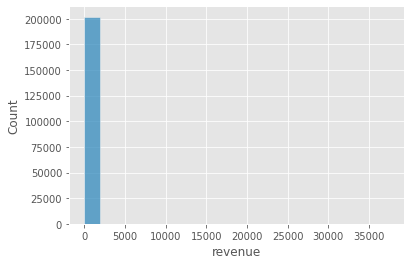

In [84]:
# посмотрим на распределение данных в контрольной группе

sns.histplot(x = 'revenue', data = control )
control.revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

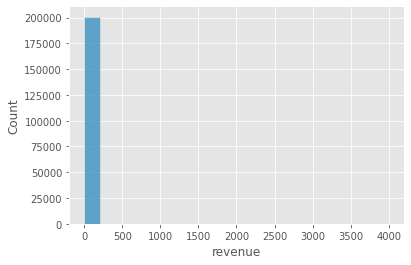

In [85]:
# посмотрим на распределение данных в тестовой группе

sns.histplot(x = 'revenue', data = test )
test.revenue.describe()

За счет нулей оба распределения скошены влево, и мы не видем рельной картины, попробуем посмотреть распределение если мы исключим ноль в данных.

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

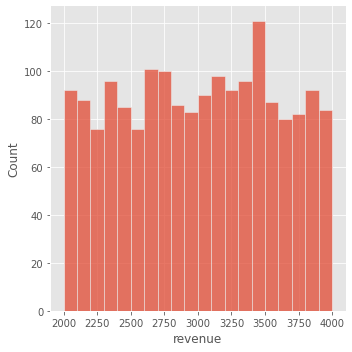

In [86]:
# распределение в тестовой группе платящих игроков
sns.displot(test_pays.revenue, aspect=1, bins=20)
test_pays.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

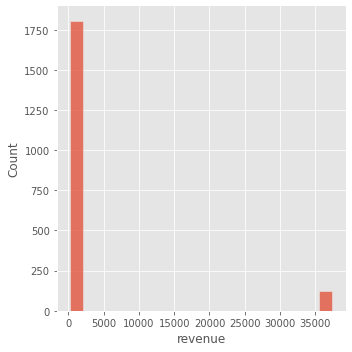

In [87]:
# распределение в контрольной группе платящих игроков
sns.displot(control_pays.revenue, aspect=1, bins=20)
control_pays.revenue.describe()

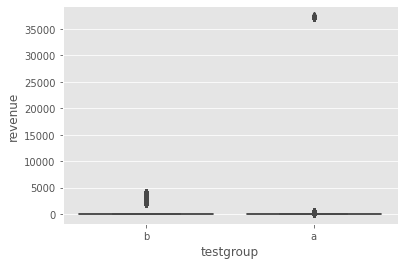

In [88]:
# так же гляним на боксплот на всех пользователей
sns.boxplot(x="testgroup", y="revenue", data=df2)

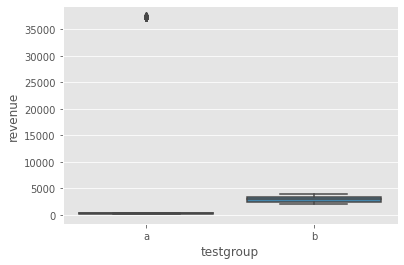

In [89]:
# и только на тех, что совершил покупку

sns.boxplot(x="testgroup", y="revenue", data=df2.query('revenue != 0'))

**На этих графиках мы видим:**


    - в тестовой группе платежи явно отличаются по сумме покупок от контрольной: 
        в тестовой распределение равномерное, 
        в контрольной большинство платежей до 500 и есть выбросы;
    - из-за выбросов в контрольной группе среднее очень сильно искажено.
    - среднее по всей выборке в контрольной группе - 25.41 и в тестовой - 26.75.
    - медиана по всей выборке в контрольной группе - 0 и в тестовой тоже 0.
    - среднее у платящих игроков в контрольной группе - 2663, а у тестовой - 3003.
    - медиана у платящих игроков в контрольной группе - 311, а у тестовой - 3022.

In [90]:
# Посмотрим что это были за выбросы и сколько их
control_pays.query('revenue > 30000')

,user_id,revenue,testgroup
416,417,37324,a
4428,4429,37304,a
5777,5778,37315,a
8065,8066,37307,a
8743,8744,37334,a
...,...,...,...
360696,360697,37347,a
378668,378669,37297,a
389341,389342,37298,a
394580,394581,37302,a


In [91]:
# Посмотрим какой процент платящих игроков совершили покупку от всех кто совершили покупку на сумму больше 30000

diff_control = (control_pays.query('revenue > 30000').shape[0]/ control_pays.query('revenue < 30000').shape[0] * 100)
diff_control = int(diff_control) 
print(f'{diff_control} % играков совершили покупку более чем на 30000')

6 % играков совершили покупку более чем на 30000


**123 пользователя уже не кажутся выбросами**
    
Необходимо более конкретно изучить данных игроков, действительно ли они делали такие покупки?

In [92]:
# Для проведения статистических тестов проверим, 
# являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

pg.homoscedasticity(data=df2, dv="revenue", group="testgroup")

,W,pval,equal_var
levene,0.389629,0.532495,True


**p-value > 0.05, данные имеют одинаковую дисперсию**

In [93]:
# проведем такую же проверку на данных без учета тех кто платил
pg.homoscedasticity(data=df2.query('revenue != 0'), dv="revenue", group="testgroup")

,W,pval,equal_var
levene,80.855674,3.779690e-19,False


**p-value < 0.05, данные имеют не одинаковую дисперсию**

In [94]:
# проведем тест на нормальность данных, мы, конечно, видим, что распределение не нормальное, 
# но все же соблюдаем все формальности. H0 - данные имеют нормальное распределение

pg.normality(data=df2, dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
b,326622.395409,0.0,False
a,585152.731273,0.0,False


**Отклоняем H0.Данные распределены не нормально**

In [95]:
# Так же проведем тест на нормальность с только для платящих пользователей, H0 - данные имеют нормальное распределение

pg.normality(data=df2.query('revenue != 0'), dv="revenue", group="testgroup", method="normaltest")

,W,pval,normal
a,1394.945784,1.234161e-303,False
b,1068.860008,7.943249e-233,False


**Отклоняем H0. Данные распределены не нормально**

In [96]:
# посмотрим действительно ли есть стат значимые различия в пропорциях игроков / платящих игроков в группах

user_pay = np.array([1805, 1928])
user = np.array([202667, 202103])
stat, pval = proportions_ztest(user_pay, user)

print(f'p-value - {pval}')


p-value - 0.035028524642854865


**p-value < 0,05, значит различия действительно значемые**

In [97]:
# при проверке данных на гомогенность и нормальность выяснилось, что дисперсии внутри групп примерно одинаковые, 
# но распределение не нормальное, более того в контрольной группе явные выбросы, по этим причинам по-моему мнению использование
# Т-теста тут не очень корректно, но проверить U-критерий Манна — Уитни можно, так как как он не чувствителен к выбросам. 

mannwhitneyu(df2[df2.testgroup == 'a'].revenue, 
             df2[df2.testgroup == 'b'].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

**U-критерий Манна — Уитни показал p-value > 0.05 а это значит, что значимых отличий в выборках нет**  

При исследовании  данных мы увидели, что платежи платящих играков между группами очень различаются, 
я считаю что нельзя оставить без внимания именно этот факт, так как страктура данных совершенно разная:

- среднее у платящих играков в контрольной группе - 2663, а у тестовой - 3003.
- медиана у платящих играков в контрольной группе - 311, а у тестовой - 3022.

При исследовании на гомогенность и нормальность выяснилось, что дисперсии внутри групп платащих играков не одинаковые, 
и распределение не норамльное, значит для исследования нам не подходит T-тест. 

Я думаю, что тут будет лучше всего, проверить нулевую гипотезу о равенстве медиан (ARPPU) с помощью бутстрапа, 
так как в контрольной группе имеются выбросы. 


In [103]:
# введем функцию для расчетна методом бутстрап

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

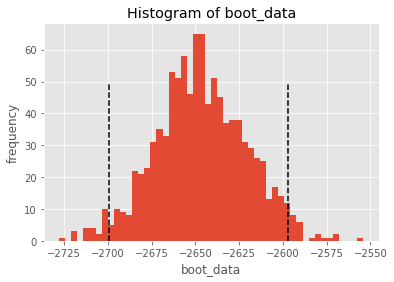

In [104]:
booted_data_median = get_bootstrap(control_pays.revenue, test_pays.revenue, statistic = np.median)

In [101]:
booted_data_median["p_value"]

0.0

In [102]:
booted_data_median['ci'] #Доверительный интервал

,0
0.025,-2695.0000
0.975,-2596.9875


**p_value < 0,05, доверительный интервал не включает 0, следовательно есть статзначемые отличия в медианах контеольной и тестовой группы.** 

_____________________________________


**ВЫВОД:**

Не смотря на то что платящих в контрольной группе оказалось больше на 7 % и это стат значимые различия, 
при проведении исследований было выявлено что в контрольной группе есть значительные выбросы, 
которые требуют дополнительного исследования.(Необходимо понимать, данные покупки совершаются на постоянно основе или это разовые)

При наличии выбросов в данных использование среднего (или ARPU) может привести к искажению результата. 
Поэтому было принято решение провести тесты по медиане (ARPPU)с использованием бутстрап. 


Тест показал стат значимые различия в медиане

 - медиана у платящих игроков в контрольной группе - 311, 
 - медиана у платящих игроков в тестовой группе - 3022.
 
**Итог:** Набор предложений в тестовой группе можно считать лучшим, так как игроки совершали более дорогие покупки.   

**Задание 3**

  1.В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. 
    В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. 
    Для получения награды требуется пройти ряд уровней за определенное время. 
    С помощью каких метрик можно оценить результаты последнего прошедшего события?



**Ответ**

**Number of unique players per event** -  первая метрика от которой нужно отталкиваться, это количество уникальных игроков которые посетили данную акцию. Сравнивать с предыдущими тематическими событиями. Это необходимо для понимания общей динамики событий.

**Event Retention** - затем я бы сегментировала игроков и посмотрела, сколько были на прошлых акциях и сколько новых игроков. Если процент возвращения большой, значит предыдущее тематическое событие прошло хорошо и люди пришли еще раз, и текущее можно оценить так же после завершения след события.  

**Average amount of time** - сколько игрок провел времени проходя данное тематическое событие. Можно посчитать среднее по дням и по всему событию, а так же по прохождению уровня.

**Levels Retention**  - количество людей переходивших на каждый уровень, что бы посмотреть интерес к событию, и на каком уровне отваливаются пользователи

**Number of earned coins and/or characters** - cколько монет и/или персонажей заработано за тематическое событие. Чем больше монет заработано, тем больше вероятность что игрок вернется в основную игру и будет там проводить больше времени и пойдет на следующее событие. Но этот показатель так же не должен быть очень большим, так как из-за лёгкости получения монет и персонажей некоторые игроки, которые любят "по сложнее" могут отвалиться.

**Number of spended coins and/or characters** - если для прохождения данной игру/события нужно покупать какое-то оборудование или еще что-то, то необходимо посчитать сколько денег принесло данное событие


**Retention** - посмотреть основной ретеншен по игре, увеличилось ли количество активных игроков после проведения данного тематического события.

**Revenue** - если в этой игре необходимо что-то покупать, посмотреть, на сколько увеличился доход после проведения события. 

Ну и какие-то не сильно очевидные метрики, которые сложнее отследить:

- упоминание данного тематического события на тематических сайтах или форумах, соц.сетях.
- если там были уникальные персонажи, которые можно,  продавать, стоимость этих персонажей. 

   2.Предположим, в другом событии мы усложнили механику событий так, 
     что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. 
     Изменится ли набор метрик оценки результата? Если да, то как?

**Ответ** При таком усложнении механики, необходимо добавить пару метрик. 

**Return_rate** - Самое главное, посмотреть, возвращаются ли игроки после того как они провалили уровень. И какой процент.

**Number of attempts** - и еще добавить метрику, которая считает, сколько было попыток после того как игрок откатился назад.